<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Correlation-of-vertex-betweenness-with-graph-energy-of-vertex-egocentric-network" data-toc-modified-id="Correlation-of-vertex-betweenness-with-graph-energy-of-vertex-egocentric-network-1" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Correlation of vertex betweenness with graph energy of vertex egocentric network</a></span><ul class="toc-item"><li><span><a href="#Graph-energy" data-toc-modified-id="Graph-energy-1.1" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Graph energy</a></span></li><li><span><a href="#Randić-energy" data-toc-modified-id="Randić-energy-1.2" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Randić energy</a></span></li><li><span><a href="#Laplacian-energy" data-toc-modified-id="Laplacian-energy-1.3" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Laplacian energy</a></span></li><li><span><a href="#Matrix-energies-for-various-topologies-of-small-egocentric-networks" data-toc-modified-id="Matrix-energies-for-various-topologies-of-small-egocentric-networks-1.4" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Matrix energies for various topologies of small egocentric networks</a></span></li></ul></li><li><span><a href="#Correlation-of-graph/Randić/Laplacian-energy-and-betweenness-in-artificial-networks" data-toc-modified-id="Correlation-of-graph/Randić/Laplacian-energy-and-betweenness-in-artificial-networks-2" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">2&nbsp;&nbsp;</span>Correlation of graph/Randić/Laplacian energy and betweenness in artificial networks</a></span></li><li><span><a href="#Visualization-of-graph-energies-centrality" data-toc-modified-id="Visualization-of-graph-energies-centrality-3" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualization of graph energies centrality</a></span></li><li><span><a href="#Regression-modeling-in-synthetic-networks" data-toc-modified-id="Regression-modeling-in-synthetic-networks-4" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">4&nbsp;&nbsp;</span>Regression modeling in synthetic networks</a></span><ul class="toc-item"><li><span><a href="#Visualization-of-the-relationship-between-vertex-betweenness-and-vertex-energies-in-random-synthetic-networks" data-toc-modified-id="Visualization-of-the-relationship-between-vertex-betweenness-and-vertex-energies-in-random-synthetic-networks-4.1" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Visualization of the relationship between vertex betweenness and vertex energies in random synthetic networks</a></span></li><li><span><a href="#Regression-modeling-for-vertex-betweenness-and-vertex-energies-in-random-synthetic-networks" data-toc-modified-id="Regression-modeling-for-vertex-betweenness-and-vertex-energies-in-random-synthetic-networks-4.2" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Regression modeling for vertex betweenness and vertex energies in random synthetic networks</a></span></li></ul></li><li><span><a href="#Empirical-networks" data-toc-modified-id="Empirical-networks-5" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">5&nbsp;&nbsp;</span>Empirical networks</a></span><ul class="toc-item"><li><span><a href="#Show-the-density-ratio-where-our-method-beats-SOTA" data-toc-modified-id="Show-the-density-ratio-where-our-method-beats-SOTA-5.1" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Show the density ratio where our method beats SOTA</a></span></li><li><span><a href="#Compute-the-correlation-of-betweenness-and-egocentric-energies" data-toc-modified-id="Compute-the-correlation-of-betweenness-and-egocentric-energies-5.2" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Compute the correlation of betweenness and egocentric energies</a></span></li><li><span><a href="#Compute-RandomForest-model-for-predicting-vertex-betweenness" data-toc-modified-id="Compute-RandomForest-model-for-predicting-vertex-betweenness-5.3" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Compute RandomForest model for predicting vertex betweenness</a></span></li><li><span><a href="#Compute-precision@k-measures-for-prediction" data-toc-modified-id="Compute-precision@k-measures-for-prediction-5.4" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Compute precision@k measures for prediction</a></span></li></ul></li><li><span><a href="#Transfer-learning" data-toc-modified-id="Transfer-learning-6" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">6&nbsp;&nbsp;</span>Transfer learning</a></span></li></ul></div>

In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tqdm
from ggplot import *

import pandas as pd
import numpy as np
import networkx as nx
import scipy, scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import logging
import requests
import itertools

import sys
sys.path.append("..")

import network_energy as ne
import utils as nu

# Correlation of vertex betweenness with graph energy of vertex egocentric network

In this experiment we are considering the measure of energy dispersion and its correlation to betweeness of vertices. There are multiple graph energies proposed in the literature, but our primary interest lies in Graph, Laplacian and Randić energies. Within the experiment we calculate the energy of each vertex by means of their ego-network. Then we compare how betweenes of vertices is correlated with the energy of their egocentric networks.

Our second experiment aims at using machine learning to predict the betweenness of a vertex from only the local information contained in the egocentric network of that vertex. Computing of betweenness requires a very costly computation of all shortest paths in the network. Our approach allows to estimate betweennes using only local information.

Finally, in our third experiment, we perform transfer learning, training a model for predicting betweenness on one network, and using this model to predict betweenness of vertices in other networks.


## Graph energy

Graph energy of a graph is defined as $E_G(G) = \sum\limits_{i=1}^n |\mu_i|$, where $\mu_1, \ldots, \mu_n$ are the eigenvalues of the adjacency matrix $M_A$ (also known as the *spectrum* of the graph).

## Randić energy

Randić matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_R(i,j)=
\begin{cases}
0 & \mathit{if} & i=j\\
\frac{1}{\sqrt{d_i d_j}} & \mathit{if} & (i,j) \in E\\
0 & \mathit{if} & (i,j) \notin E
\end{cases}
$$

Randić energy of a graph is defined as $E_R(G) = \sum\limits_{i=1}^n |\rho_i|$, where $\rho_1, \ldots, \rho_n$ are the eigenvalues of the Randić matrix $M_R$.

## Laplacian energy

Laplacian matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_L(i,j)=
\begin{cases}
d_i & \mathit{if} & i=j\\
-1 & \mathit{if} & (i,j) \in E\\
0 & \mathit{otherwise}
\end{cases}
$$

Laplacian energy of a graph is defined as $E_L(G) =  \sum\limits_{i=1}^n |\lambda_i - \frac{2m}{n}|$, where $\lambda_1, \ldots, \lambda_n$ are the eigenvalues of the Laplacian matrix $M_L$, $n$ is the number of vertices and $m$ is the number of edges in the graph $G$.

In [ ]:
def chunks(lst, n):
    """
    Divide a list of vertices `lst` into chunks consisting of `n` vertices
    
    Tests:
    >>> list(chunks([1,2,3,4,5,6], 2))
    [(1, 2), (3, 4), (5, 6)]

    >>> list(chunks([1,2,3,4,5,6], 4))
    [(1, 2, 3, 4), (5, 6)]

    >>> list(chunks([], 2))
    []

    """
    _lst = iter(lst)
    while 1:
        x = tuple(itertools.islice(_lst, n))
        if not x:
            return
        yield x
        
def normalize_df_column(df_column):
    """
    Normalize a dataframe column to the range [0,1]
    
    Tests:
    >>> normalize_df_column(pd.Series([1,2,3,4,5]))
    array([[0.  ],
           [0.25],
           [0.5 ],
           [0.75],
           [1.  ]])
    """
    x = df_column.values.astype(float)
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    
    return x_scaled

In [ ]:
import doctest
doctest.testmod()

## Matrix energies for various topologies of small egocentric networks

Firstly, let us examine the relationship between the topology of a small egocentric network and its energies. We generate five different egocentric networks representing possible small scale configurations and compute all three types of matrix energies. The results are somehow surprising, graph energy tends to correlate with the degree of connectivity of the egocentric network, Randic energy remains practically constant, and Laplacian energy behaves unpredictably, receiving the maximum value for a custom topology. 

/home/mikolaj/.virtualenvs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/mikolaj/.virtualenvs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/mikolaj/.virtualenvs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/mikolaj/.virtualenvs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/mikolaj/.virtualenvs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


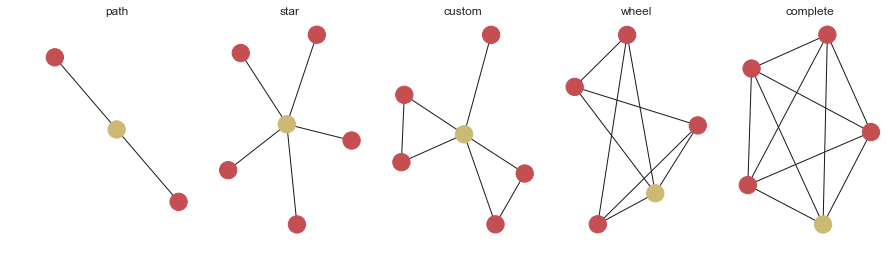

\begin{tabular}{lrrr}
\toprule
     name &  graph energy &  randic energy &  laplacian energy \\
\midrule
     path &      2.828427 &       2.000000 &          3.333333 \\
     star &      4.472136 &       2.000000 &          8.666667 \\
   custom &      7.806424 &       3.306226 &         10.000000 \\
    wheel &      6.472136 &       2.000000 &          7.200000 \\
 complete &      8.000000 &       2.000000 &          8.000000 \\
\bottomrule
\end{tabular}



In [287]:
g_custom = nx.star_graph(n=5)
g_custom.add_edge(1,2)
g_custom.add_edge(4,5)

graphs = [
    {'name': 'path', 'graph': nx.path_graph(n=3)},
    {'name': 'star', 'graph': nx.star_graph(n=5)},
    {'name': 'custom', 'graph': g_custom},
    {'name': 'wheel', 'graph': nx.wheel_graph(n=5)},
    {'name': 'complete', 'graph': nx.complete_graph(n=5)}
]

sns.set(rc={'figure.figsize': (15, 4)})
fig, ax = plt.subplots(5, 1)

df = pd.DataFrame(
    {'name': [ g['name'] for g in graphs],
     'graph energy': [ne.get_graph_energy(g['graph']) for g in graphs],
     'randic energy': [ne.get_randic_energy(g['graph']) for g in graphs],
     'laplacian energy': [ne.get_laplacian_energy(g['graph']) for g in graphs]
    }
)

plt.subplot(151)
nx.draw(graphs[0]['graph'], node_color=['r','y','r'])
plt.title(graphs[0]['name'])

plt.subplot(152)
nx.draw(graphs[1]['graph'], node_color=['y','r', 'r', 'r', 'r', 'r'])
plt.title(graphs[1]['name'])

plt.subplot(153)
nx.draw(graphs[2]['graph'], node_color=['y','r','r', 'r', 'r', 'r'])
plt.title(graphs[2]['name'])

plt.subplot(154)
nx.draw(graphs[3]['graph'], node_color=['y','r','r', 'r', 'r'])
plt.title(graphs[3]['name'])

plt.subplot(155)
nx.draw(graphs[4]['graph'], node_color=['y','r','r', 'r', 'r'])
plt.title(graphs[4]['name'])

plt.show()

print(df[['name', 'graph energy', 'randic energy', 'laplacian energy']].to_latex(index=False))

Next, we start with a star configuration of an egocentric network consisting of an ego and additional $n$ vertices, and we gradually add all remaining edges, until we form a full $K_5$ graph. For each intermediate graph we compute all its energies. We can clearly see that each of matrix energies is measuring a different "aspect" of the egocentric network:

* randic energy is maximized for topologies very close to the original star-like structure and diminishes as more and more edges are added to the egocentric network
* laplacian energy strongly resembles the entropy of adjacency matrix, being maximized half-way between the star structure and the clique structure of the egocentric network
* graph energy steadily grows as the density of the egocentric network increases.

In [303]:
from itertools import combinations
from random import shuffle

g = nx.star_graph(n=25)

results = []

edges = list(combinations(range(1, len(g.nodes)), r=2))

# comment if you want to add edges in an ordered way
shuffle(edges)

for (idx, (i, j)) in enumerate(edges):
    results.append((idx, ne.get_graph_energy(g), ne.get_randic_energy(g),
                    ne.get_laplacian_energy(g)))

    g.add_edge(i, j)

In [304]:
df = pd.DataFrame(
    data=results,
    columns=[
        'complexity', 'graph energy', 'randic energy', 'laplacian energy'
    ])

dfn = df[['graph energy','randic energy','laplacian energy']].apply(lambda s: s/s.max(), axis=0)
dfn['complexity'] = df['complexity']

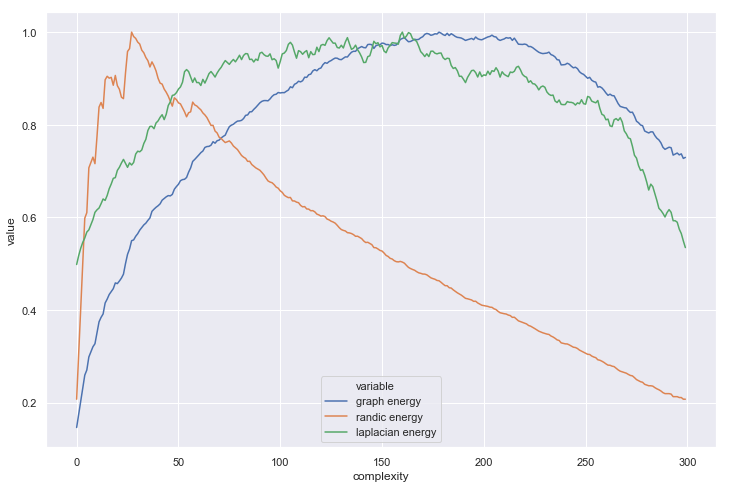

In [305]:
dfm = pd.melt(
    dfn,
    value_vars=['graph energy', 'randic energy', 'laplacian energy'],
    id_vars='complexity')

sns.set(rc={'figure.figsize': (12, 8)})
sns.lineplot(data=dfm, x='complexity', y='value', hue='variable')

# Correlation of graph/Randić/Laplacian energy and betweenness in artificial networks

In this experiment we create several instances of networks generated by two popular models:

- Erdos-Renyi random network model
- Barabasi-Albert preferential attachment model

and for each network we modify its main generative parameter. For each network we collect detailed statistics on every node:

- its betweenness,
- its Randić energy,
- its Laplacian energy,
- and its graph energy.

We normalize these variables using MinMax scaling to the range of [0-1]. Finally, we group the data by network model and network model parameter used to generate a given network instance, and for each such combination we compute the correlation of 



In [ ]:
num_nodes = 250

results = pd.DataFrame(columns=['node',
                                'betweenness',
                                'randic_energy',
                                'graph_energy',
                                'network_model',
                                'network_model_param'])

# iterate over different parameter settings
network_model_params = [p/100 for p in range(1, 10)]

# radius of egocentric networks for energy computation
radius = 1

# sizes of groups for SBM
sizes = [50, 50, 150]

# intra- and inter-densities of edges between groups in SBM


def pa(): return np.random.uniform(0, 0.1)


def pb(): return np.random.uniform(0.2, 0.3)


for p in tqdm(network_model_params):

    b = 0.4
    
    probs = np.matrix([[b, p, p],
                       [p, b, p],
                       [p, p, b]])

    # symmetrize the matrix
    probs = np.maximum(probs, probs.T)

    # generate random and power-law networks with n=500 and p=0.01, 0.02, ..., 0.10
    generators = {
        'random': nx.erdos_renyi_graph(n=num_nodes, p=p),
        'powerlaw': nx.powerlaw_cluster_graph(n=num_nodes, m=2, p=p),
        'sbm': nx.stochastic_block_model(sizes=sizes, p=np.array(probs))
    }

    for generator in generators.keys():

        G = generators[generator]

        be = nx.betweenness_centrality(G, k=None, normalized=True)
        re = ne.randic_centrality(G, radius=radius, normalized=True)
        ge = ne.graph_energy_centrality(G, radius=radius, normalized=True)
        le = ne.laplacian_centrality(G, radius=radius, normalized=True)

        _dict = {
            'node': list(G.nodes),
            'betweenness': list(be.values()),
            'randic_energy': list(re.values()),
            'graph_energy': list(ge.values()),
            'laplacian_energy': list(le.values()),
            'network_model': [generator] * G.number_of_nodes(),
            'network_model_param': [p] * G.number_of_nodes()
        }

        _result = pd.DataFrame.from_dict(_dict)

        results = pd.concat([results, _result], axis=0)

In [ ]:
print(results[[
    'network_model',
    'betweenness', 
    'randic_energy',
    'graph_energy',
    'laplacian_energy']].describe().round(4).to_latex())

In [ ]:
# what is the correlation between betweenness and randić energy for different models?
_results = results.groupby(
    ['network_model_param',
     'network_model'])[['betweenness',
                        'randic_energy', 
                        'graph_energy',
                        'laplacian_energy']].corr().reset_index()

# extract correlations for the two models
powerlaw_idx = _results['network_model'] == 'powerlaw'
random_idx = _results['network_model'] == 'random'
sbm_idx = _results['network_model'] == 'sbm'

powerlaw_corr = _results[powerlaw_idx]['betweenness'].tolist()
random_corr = _results[random_idx]['betweenness'].tolist()
sbm_corr = _results[sbm_idx]['betweenness'].tolist()

# get additional columns with network model parameter and type of energy
network_model_param = _results[random_idx]['network_model_param'].tolist()
energy_idx = _results[random_idx]['level_2'].tolist()

correlations = pd.DataFrame({'p': network_model_param, 
                             'energy': energy_idx,
                             'powerlaw': powerlaw_corr, 
                             'random': random_corr,
                             'sbm': sbm_corr})

# melt the DataFrame to a format more suitable for drawing
correlations_mlt = pd.melt(correlations[correlations['energy'] != 'betweenness'], 
                id_vars=['p','energy'], 
                value_vars=['powerlaw','random','sbm'], 
                var_name='network_model', 
                value_name='correlation')

In [ ]:
g = sns.FacetGrid(correlations_mlt, col='energy', hue='network_model', height=8)
g.map(sns.lineplot, 'p', 'correlation')
g.add_legend()

# Visualization of graph energies centrality

We visualize Randić, Laplacian and graph energy for the well-known Zachary karate club network. The energy of each vertex is denoted by its color and size. As can be seen, the correlation between these centralities is very high and they all provide similar information. Also, one can see that these centralities have strong preference to nodes that are either central to their cluster, or lying in between clusters.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

norm = lambda lst: minmax.fit_transform(np.asarray(lst, dtype=np.float32).
                                        reshape(-1,1)).reshape(-1).tolist()

g = nx.karate_club_graph()

re = list(ne.randic_centrality(g).values())
re = norm(re)

le = list(ne.laplacian_centrality(g).values())
le = norm(le)

ge = list(ne.graph_energy_centrality(g).values())
ge = norm(ge)

sns.set(rc={'figure.figsize':(11.7,8.27)})

fig, ax = plt.subplots(3,1)

plt.subplot(131)
options = { 
    'node_color': [d * 1 for d in ge], 
    'node_size': [d * 1000 for d in ge], 
    'cmap': plt.cm.Greens,
    'edge_color': 'gray' 
}
nx.draw_kamada_kawai(g, **options)
plt.title('Graph energy')

plt.subplot(132)
options = { 
    'node_color': [d * 1 for d in le], 
    'node_size': [d * 1000 for d in le], 
    'cmap': plt.cm.Oranges,
    'edge_color': 'gray' 
}
nx.draw_kamada_kawai(g, **options)
plt.title('Laplacian energy')

plt.subplot(133)
options = { 
    'node_color': [d * 1 for d in re], 
    'node_size': [d * 1000 for d in re], 
    'cmap': plt.cm.Purples,
    'edge_color': 'gray'
}
nx.draw_kamada_kawai(g, **options)
plt.title('Randić energy')

plt.show()

# Regression modeling in synthetic networks

As the next step we fit regression models and compute their accuracy in terms of

  * Pearson, Spearman, and Kendall correlations
  * mean absolute error
  * mean squarred error
  
In the experiment we fit various regressors:

- simple linear model
- random forest regressor
- gradient boosting regressor

We collect the data from generative network models, and for each vertex we note its betweenness and its energies. Then, we fit these three regressors for networks generated for a particular value of the generative attribute.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau, rankdata

regression_models = {
    'linear model': LinearRegression(), 
    'random forest': RandomForestRegressor(), 
    'gradient boosting': GradientBoostingRegressor()
}

prediction_results = []

for network_model in results['network_model'].unique():
    for network_model_param in network_model_params:
        
        model_idx = results['network_model'] == network_model
        param_idx = results['network_model_param'] == network_model_param
        
        df = results[ model_idx & param_idx]
        
        y = df['betweenness'].values
        X = df[['randic_energy','graph_energy','laplacian_energy']].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
        for regression_model in regression_models:
            
            l_model = regression_models[regression_model]
            
            l_model.fit(X=X_train, y=y_train)
            y_pred = l_model.predict(X_test)

            y_ranked = rankdata(y_test, method='ordinal') 
            y_pred_ranked = rankdata(y_pred, method='ordinal')

            _dict = {
                'regression_model': regression_model,
                'network_model': network_model,
                'network_model_param': network_model_param,
                'mae': mean_absolute_error(y_true=y_test, y_pred=y_pred),
                'mse': mean_squared_error(y_true=y_test, y_pred=y_pred),
                'r2': r2_score(y_test, y_pred),
                'pearson': pearsonr(y_test, y_pred)[0],
                'spearman': spearmanr(y_test, y_pred, axis=0, nan_policy='propagate')[0],
                'kendall': kendalltau(y_ranked, y_pred_ranked, initial_lexsort=None, nan_policy='propagate')[0]
            }

            prediction_results.append(_dict)

# convert the list of dicts into a DataFrame
prediction_results = pd.DataFrame(prediction_results, 
             columns=['regression_model', 
                      'network_model',
                      'network_model_param', 
                      'mae', 
                      'mse', 
                      'r2', 
                      'pearson', 
                      'spearman', 
                      'kendall'])

# melt DataFrame to transform it into tidy format
prediction_results_mlt = pd.melt(prediction_results,
                             id_vars=['regression_model', 'network_model','network_model_param'], 
                             var_name='measure',
                             value_name='value')

In [ ]:
df = pd.pivot_table(prediction_results_mlt.round(2), 
                    index=['network_model','regression_model'], 
                    columns='measure', 
                    values='value').rename_axis(None, axis=1)

print(df[['mae','mse','r2','kendall','spearman','pearson']].describe().round(4).to_latex())
print(df[['mae','mse','r2','kendall','spearman','pearson']].round(4).to_latex())

## Visualization of the relationship between vertex betweenness and vertex energies in random synthetic networks

The following figures show the linear model predicting vertex betweenness based on graph energy, Randić energy, and Laplacian energy for random and powerlaw networks for a fixed value of the generative parameter. The value of the parameter is drawn randomly from the entire domain of the parameter.

In [ ]:
network_model = 'random'
network_model_param = np.random.choice(network_model_params)

sns.jointplot(x='randic_energy',
              y='betweenness', 
              data=results[(results['network_model'] == network_model) 
                           & (results['network_model_param'] == network_model_param)], 
              kind='reg', 
              color="xkcd:sky blue")

sns.jointplot(x='graph_energy', 
              y='betweenness',
              data=results[(results['network_model'] == network_model) 
                           & (results['network_model_param'] == network_model_param)], 
              kind="reg", 
              color="xkcd:strawberry")

sns.jointplot(x='laplacian_energy', 
              y='betweenness',
              data=results[(results['network_model'] == network_model) 
                           & (results['network_model_param'] == network_model_param)], 
              kind="reg", 
              color="xkcd:blue gray")


In [ ]:
network_model = 'powerlaw'
network_model_param = np.random.choice(network_model_params)

sns.jointplot(x='randic_energy', 
              y='betweenness', 
              data=results[(results['network_model'] == network_model)
                          & (results['network_model_param'] == network_model_param)], 
              kind='reg', 
              color="xkcd:medium blue")

sns.jointplot(x='graph_energy', 
              y='betweenness',
              data=results[(results['network_model'] == network_model)
                          & (results['network_model_param'] == network_model_param)], 
              kind="reg", 
              color="xkcd:pumpkin orange")

sns.jointplot(x='laplacian_energy', 
              y='betweenness',
              data=results[(results['network_model'] == network_model)
                          & (results['network_model_param'] == network_model_param)], 
              kind="reg", 
              color="xkcd:moss green")

In [ ]:
network_model = 'sbm'
network_model_param = np.random.choice(network_model_params)

sns.jointplot(x='randic_energy', 
              y='betweenness', 
              data=results[(results['network_model'] == network_model)
                          & (results['network_model_param'] == network_model_param)], 
              kind='reg', 
              color="xkcd:cornflower blue")

sns.jointplot(x='graph_energy', 
              y='betweenness',
              data=results[(results['network_model'] == network_model)
                          & (results['network_model_param'] == network_model_param)], 
              kind="reg", 
              color="xkcd:burnt orange")

sns.jointplot(x='laplacian_energy', 
              y='betweenness',
              data=results[(results['network_model'] == network_model)
                          & (results['network_model_param'] == network_model_param)], 
              kind="reg", 
              color="xkcd:teal green")

## Regression modeling for vertex betweenness and vertex energies in random synthetic networks

Below we present correlation measures (Pearson, Spearman, Kendall) which describe the relationship of betweenness and vertex energies (Randic, Laplacian and Graph). We randomly select the value of the network generator parameter and repeat the correlation computation, averaging the results over 1000 runs.

In [ ]:
result = []

number_of_runs = 1000


for network_model in results.network_model.unique():
    for run in tqdm(range(number_of_runs)):
        
        network_model_param = np.random.choice(network_model_params)

        network_model_idx = results['network_model'] == network_model
        network_model_param_idx = results['network_model_param'] == network_model_param

        for method in ['kendall','spearman','pearson']:

            _corr = results[network_model_idx & network_model_param_idx][
                ['betweenness',
                 'randic_energy',
                 'graph_energy',
                 'laplacian_energy']].corr(method=method)
            
            result.append((network_model, 
                           network_model_param, 
                           method, 
                           _corr.betweenness['randic_energy'], 
                           _corr.betweenness['graph_energy'],
                           _corr.betweenness['laplacian_energy']))
        
correlations = pd.DataFrame(result, 
                            columns=['network_model', 
                                     'network_model_param',
                                     'method', 
                                     'BRC', 
                                     'BGC',
                                     'BLC'])

In [ ]:
print(correlations[[
    'network_model', 
    'method', 
    'BRC', 
    'BGC', 
    'BLC']].groupby([
        'network_model', 
        'method']).mean().to_latex())

In [ ]:
# melt DataFrame to transform it into tidy format
correlations_mlt = pd.melt(correlations,
                             id_vars=['network_model','network_model_param', 'method'], 
                             var_name='measure',
                             value_name='correlation')

In [ ]:
sns.reset_defaults()

g = sns.FacetGrid(correlations_mlt, col='network_model', row='measure', hue='method', height=5, sharey=False)
g.map(sns.lineplot, 'network_model_param', 'correlation')
g.add_legend()

# Empirical networks

In this experiment we are trying to verify if the relationship between vertex energies and vertex betweenness holds also in empirical networks. We download a set of networks from the Koblenz network repository and compute the basic statistics of these networks.

In [106]:
available_networks = nu.read_avalilable_datasets_konect()

In [107]:
import utils as nu

from collections import namedtuple

Network = namedtuple('Network', 'name category num_nodes num_edges graph')

min_size = 30
max_size = 1000
max_density = 0.5

dir_name = 'data/'

In [ ]:
networks = []

for (network_name, network_category, num_nodes, num_edges) in tqdm(available_networks):
    networks.append(
        Network(name=network_name,
                category=network_category,
                num_nodes=num_nodes,
                num_edges=num_edges,
                graph=nu.build_network_from_out_konect(network_name=network_name,
                                                       dir_name=dir_name,
                                                       num_nodes=num_nodes,
                                                       num_edges=num_edges,
                                                       min_size=min_size,
                                                       max_size=max_size,
                                                       max_density=max_density
                                                       ))
    )

In [ ]:
import pickle

# remove networks that were too large
networks = list(filter(lambda n: n.graph is not None, networks))

print('Number of networks: ', len(networks))

with open('networks.pickle','wb') as f:
    pickle.dump(networks, f)

In [108]:
import pickle

with open('networks.pickle','rb') as f:
    networks = pickle.load(f)
    
print('Number of empirical networks: ', len(networks))

Number of empirical networks:  223


In [109]:
networks = [
    n
    for n
    in networks
    if n.num_nodes < 500
]

print('Number of empirical networks after filtering: ', len(networks))

Number of empirical networks after filtering:  118


In [110]:
networks = networks[:100]

## Show the density ratio where our method beats SOTA

Our initial analysis points to a certain area of the (#vertices, avg.degree) parameter space, where our method of betweenness estimation should perform better than the best currently known exact algorithm of betweenness estimation. 

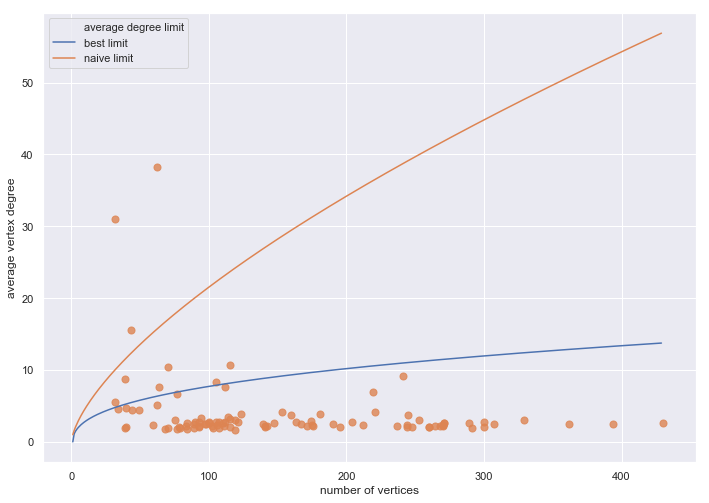

In [286]:
x = range(1, max([n.num_nodes for n in networks]))
y1 = np.power(x * np.log(x), 1 / 3)
y2 = np.power(x, 2 / 3)

df = pd.DataFrame({
    'num vertices': x,
    'best limit': y1,
    'naive limit': y2
}).melt(
    id_vars=['num vertices'], var_name='average degree limit')

sns.set(rc={'figure.figsize': (11.7, 8.27)})

figure = sns.lineplot(
    data=df, x='num vertices', y='value', hue='average degree limit')

plt.xlabel('number of vertices')
plt.ylabel('average vertex degree')

ax = sns.regplot(
    x=[n.num_nodes for n in networks],
    y=[2*n.num_edges/n.num_nodes for n in networks],
    scatter=True,
    fit_reg=False,
    marker='o',
    scatter_kws={"s": 50})
# the "s" key in `scatter_kws` modifies the size of the marker

network_data_labels = [
    (n.num_nodes, 2*n.num_edges/n.num_nodes, n.name)
    for n
    in networks
]

# [
#     ax.text(p[0] + 2, p[1] + 3, p[2])
#     for p in network_data_labels
#     if p[1] > 5
# ]

plt.show(figure)

## Compute the correlation of betweenness and egocentric energies

Firstly we calculate betweenness and energy measures for each vertex

In [48]:
real_data_measures = pd.DataFrame(columns=['node',
                                           'value_type',
                                           'value',
                                           'network',
                                           'category',
                                           'num_nodes',
                                           'num_edges'])

for n in tqdm(networks):

    G = n.graph

    be = nx.betweenness_centrality(G, k=None, normalized=True)
    tmp_df = pd.DataFrame({'node': [i[0] for i in be.items()],
                           'value_type': ['betweenness' for i in be.items()],
                           'value': [i[1] for i in be.items()],
                           'network': [n.name for j in be.items()],
                           'category': [n.category for j in be.items()],
                           'num_nodes': [n.num_nodes for j in be.items()],
                           'num_edges': [n.num_edges for j in be.items()]
                           })
    real_data_measures = pd.concat([real_data_measures, tmp_df])

    re = ne.randic_centrality(G, normalized=True)
    tmp_df = pd.DataFrame({'node': [i[0] for i in re.items()],
                           'value_type': ['randic' for i in re.items()],
                           'value': [i[1] for i in re.items()],
                           'network': [n.name for j in be.items()],
                           'category': [n.category for j in be.items()],
                           'num_nodes': [n.num_nodes for j in be.items()],
                           'num_edges': [n.num_edges for j in be.items()]
                           })
    real_data_measures = pd.concat([real_data_measures, tmp_df])

    ge = ne.graph_energy_centrality(G, normalized=True)
    tmp_df = pd.DataFrame({'node': [i[0] for i in ge.items()],
                           'value_type': ['graph' for i in ge.items()],
                           'value': [i[1] for i in ge.items()],
                           'network': [n.name for j in be.items()],
                           'category': [n.category for j in be.items()],
                           'num_nodes': [n.num_nodes for j in be.items()],
                           'num_edges': [n.num_edges for j in be.items()]
                           })
    real_data_measures = pd.concat([real_data_measures, tmp_df])

    le = ne.laplacian_centrality(G, normalized=True)
    tmp_df = pd.DataFrame({'node': [i[0] for i in le.items()],
                           'value_type': ['laplacian' for i in le.items()],
                           'value': [i[1] for i in le.items()],
                           'network': [n.name for j in be.items()],
                           'category': [n.category for j in be.items()],
                           'num_nodes': [n.num_nodes for j in be.items()],
                           'num_edges': [n.num_edges for j in be.items()]
                           })
    real_data_measures = pd.concat([real_data_measures, tmp_df])
    
real_data_measures.to_pickle('./real_data_measures.pickle')

In [50]:
real_data_measures = pd.read_pickle('./real_data_measures.pickle')

In [119]:
def evaluate_results(network, y, y_pred, energy_name):

    y_ranked = scipy.stats.rankdata(y, method='ordinal')  # może metoda average
    y_pred_ranked = scipy.stats.rankdata(y_pred, method='ordinal')
    
    real_prediction_results = pd.DataFrame(
        columns=[
            'network', 
            'category', 
            'num_nodes',
            'num_edges',
            'error_type', 
            'error_value',
            'energy'
        ]
    )

    mae = sklearn.metrics.mean_absolute_error(y_true=y, y_pred=y_pred)
    tmp_df = pd.DataFrame({
        'network': [network.name],
        'category': [network.category],
        'num_nodes': [network.num_nodes],
        'num_edges': [network.num_edges],
        'error_type': ['MAE'],
        'error_value': [mae],
        'energy': [energy_name]
    })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])

    mse = sklearn.metrics.mean_squared_error(y_true=y, y_pred=y_pred)
    tmp_df = pd.DataFrame({
        'network': [network.name],
        'category': [network.category],
        'num_nodes': [network.num_nodes],
        'num_edges': [network.num_edges],
        'error_type': ['MSE'],
        'error_value': [mse],
        'energy': [energy_name]
    })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])

    r2 = sklearn.metrics.r2_score(y_true=y, y_pred=y_pred)
    tmp_df = pd.DataFrame({
        'network': [network.name],
        'category': [network.category],
        'num_nodes': [network.num_nodes],
        'num_edges': [network.num_edges],
        'error_type': ['r2'],
        'error_value': [r2],
        'energy': [energy_name]
    })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])
    
    pearson, _ = scipy.stats.pearsonr(x=y, y=y_pred)
    tmp_df = pd.DataFrame({
        'network': [network.name],
        'category': [network.category],
        'num_nodes': [network.num_nodes],
        'num_edges': [network.num_edges],
        'error_type': ['pearson'],
        'error_value': [pearson],
        'energy': [energy_name]
    })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])

    spearman, _ = scipy.stats.spearmanr(
        a=y, b=y_pred, axis=0, nan_policy='propagate')
    tmp_df = pd.DataFrame({
        'network': [network.name],
        'category': [network.category],
        'num_nodes': [network.num_nodes],
        'num_edges': [network.num_edges],
        'error_type': ['spearman'],
        'error_value': [spearman],
        'energy': [energy_name]
    })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])

    kendall, _ = scipy.stats.kendalltau(
        x=y_ranked, y=y_pred_ranked, initial_lexsort=None, nan_policy='propagate')
    tmp_df = pd.DataFrame({
        'network': [network.name],
        'category': [network.category],
        'num_nodes': [network.num_nodes],
        'num_edges': [network.num_edges],
        'error_type': ['kendall'],
        'error_value': [kendall],
        'energy': [energy_name]
    })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])

    return real_prediction_results

## Compute RandomForest model for predicting vertex betweenness

Next step is to use data on vertex betweenness and vertex energy to build RandomForest models for predicting betweenness from local egocentric network energy

In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

models = []

df = pd.DataFrame(columns=[
    'network', 
    'category', 
    'num_nodes',
    'num_edges',
    'error_type', 
    'error_value'
])

for network in tqdm(networks):

    l_model = RandomForestRegressor()

    y = real_data_measures[(real_data_measures['network'] == network.name) &
                           (real_data_measures['value_type'] == 'betweenness')
                           ]['value'].values

    for energy_name in ['graph','laplacian','randic']:
        
        X = real_data_measures[(real_data_measures['network'] == network.name) &
                               (real_data_measures['value_type'] == energy_name)
                               ]['value'].values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

        l_model.fit(X_train.reshape(-1, 1), y_train)

        models.append(l_model)

        y_pred = l_model.predict(X_test.reshape(-1, 1))

        df = pd.concat(
            [df, evaluate_results(network, y_test, y_pred, energy_name)])

df.to_pickle('./real_prediction_results.pickle')

In [162]:
df = pd.read_pickle('./real_prediction_results.pickle')

In [163]:
df = pd.pivot_table(df.round(3), 
                    index=['category','network','num_nodes','num_edges','energy'], 
                    columns='error_type', 
                    values='error_value').rename_axis(None, axis=1).reset_index()

In [164]:
for energy in df.energy.unique():
    
    energy_idx = df['energy'] == energy
    
    print(df[energy_idx][['MAE','MSE','r2','kendall','spearman','pearson']].describe().round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &     MAE &     MSE &      r2 &  kendall &  spearman &  pearson \\
\midrule
count &  100.00 &  100.00 &  100.00 &   100.00 &     99.00 &    99.00 \\
mean  &    0.01 &    0.00 &    0.51 &     0.88 &      0.89 &     0.87 \\
std   &    0.01 &    0.01 &    0.61 &     0.17 &      0.16 &     0.17 \\
min   &    0.00 &    0.00 &   -3.48 &    -0.07 &     -0.09 &    -0.19 \\
25\%   &    0.00 &    0.00 &    0.40 &     0.84 &      0.84 &     0.80 \\
50\%   &    0.00 &    0.00 &    0.64 &     0.95 &      0.97 &     0.93 \\
75\%   &    0.01 &    0.00 &    0.84 &     0.99 &      1.00 &     0.98 \\
max   &    0.09 &    0.03 &    1.00 &     1.00 &      1.00 &     1.00 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
{} &     MAE &     MSE &      r2 &  kendall &  spearman &  pearson \\
\midrule
count &  100.00 &  100.00 &  100.00 &   100.00 &     99.00 &    99.00 \\
mean  &    0.01 &    0.00 &    0.37 &     0.89 &      0.90 &     0.90 \\
std   &    0.0

In [165]:
print(df[df['category'] != 'Authorship network'].sample(20).round(2).to_latex(index=False))

\begin{tabular}{llrrlrrrrrr}
\toprule
               category &                       network &  num\_nodes &  num\_edges &     energy &   MAE &   MSE &  kendall &  pearson &    r2 &  spearman \\
\midrule
         Animal network &                   moreno\_hens &         32 &        496 &  laplacian &  0.00 &  0.00 &     1.00 &      NaN &  1.00 &       NaN \\
    Affiliation network &  brunson\_corporate-leadership &         44 &         99 &     randic &  0.01 &  0.00 &     1.00 &     0.81 & -0.08 &      0.98 \\
        Trophic network &           dimacs10-chesapeake &         39 &        170 &     randic &  0.01 &  0.00 &     0.14 &     0.94 & -0.10 &      0.29 \\
   Human social network &             moreno\_innovation &        241 &       1098 &     randic &  0.00 &  0.00 &     0.56 &     0.75 &  0.47 &      0.73 \\
 Infrastructure network &                contiguous-usa &         49 &        107 &     randic &  0.02 &  0.00 &     0.60 &     0.82 &  0.67 &      0.80 \\
   Human soc

## Compute precision@k measures for prediction

In this experiment we compute rankings of nodes based on their true and estimated betweenness, and we compare these rankings using precision@k measure for k=1, 10, 100. We are interested to see what percentage of "important" nodes we can extract using our method.

In [131]:
def precision_at_k(y_true, y_pred, k=1):
    """
    Computes precision@k metric for ranking lists
    
    params:
    :param y_true: list of real ranking of items
    :param y_pred: list of predicted ranking of items
    :param k: cut off value
    
    Tests:
    >>> precision_at_k([1,2,3,4,5],[1,2,3,8,9],3)
    1.0
    >>> precision_at_k([1,2,3,4,5],[1,2,3,8,9],4)
    0.75
    >>> precision_at_k([1,2,3,4,5],[9,8,7,6,5],3)
    0.0
    """
    
    assert isinstance(k, int), 'k must be an integer'
    assert (k > 0), 'k must be positive'
    
    common = set(y_pred[:k]).intersection(set(y_true[:k]))
    return len(common)/k

import doctest
doctest.testmod()

TestResults(failed=0, attempted=3)

In [132]:
results = []

for network in tqdm(networks):

    be = nx.betweenness_centrality(network.graph)
    ge = ne.graph_energy_centrality(network.graph)
    le = ne.laplacian_centrality(network.graph)
    re = ne.randic_centrality(network.graph)
    
    for (energy_name, energy_values) in [('graph', ge), ('laplacian', le), ('randić', re)]:

        ranking_true = sorted(be, key=be.get, reverse=True)
        ranking_pred = sorted(energy_values, key=energy_values.get, reverse=True)

        results.append(
            (
                network.category,
                network.name,
                energy_name,
                precision_at_k(y_true=ranking_true, y_pred=ranking_pred, k=1),
                precision_at_k(y_true=ranking_true, y_pred=ranking_pred, k=10),
                precision_at_k(y_true=ranking_true, y_pred=ranking_pred, k=100)
            )
        )

df = pd.DataFrame(results,
                  columns=[
                      'category',
                      'network',
                      'energy',
                      'precision@1',
                      'precision@10',
                      'precision@100'
                  ])

df.to_pickle('./real_precision_at_k.pickle')

In [150]:
df = pd.read_pickle('./real_precision_at_k.pickle')

In [151]:
df.energy.unique()

array(['graph', 'laplacian', 'randić'], dtype=object)

In [152]:
for energy in df.energy.unique():
    
    energy_idx = df['energy'] == energy

    print(df[energy_idx].describe().round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  precision@1 &  precision@10 &  precision@100 \\
\midrule
count &       100.00 &        100.00 &         100.00 \\
mean  &         0.76 &          0.76 &           0.87 \\
std   &         0.43 &          0.17 &           0.21 \\
min   &         0.00 &          0.00 &           0.18 \\
25\%   &         1.00 &          0.70 &           0.82 \\
50\%   &         1.00 &          0.80 &           0.98 \\
75\%   &         1.00 &          0.90 &           1.00 \\
max   &         1.00 &          1.00 &           1.00 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  precision@1 &  precision@10 &  precision@100 \\
\midrule
count &       100.00 &        100.00 &         100.00 \\
mean  &         0.48 &          0.83 &           0.88 \\
std   &         0.50 &          0.15 &           0.21 \\
min   &         0.00 &          0.10 &           0.18 \\
25\%   &         0.00 &          0.80 &           0.88 \\
50\%   &         0.00 &          0.90 & 

# Transfer learning

In this experiment we check if it is possible to train the regression model on one network and then transfer the same model to other networks. In other words, if the relationship between vertex betweenness and vertex energy is universal, such transfer learning should be possible.

In [157]:
real_data_measures.value_type.unique()

array(['betweenness', 'randic', 'graph', 'laplacian'], dtype=object)

In [233]:
real_data_measures = pd.read_pickle('./real_data_measures.pickle')

In [276]:
transfer_real_prediction_results = pd.DataFrame(
    columns=['network', 'error_type', 'error_value', 'source_network'])

for source_network in tqdm(networks[:50]):
    for target_network in tqdm(networks[:50]):
        
        y_source = real_data_measures[(real_data_measures['network'] == source_network.name) &
                               (real_data_measures['value_type']
                                == 'betweenness')
                               ]['value'].values
        y_target = real_data_measures[(real_data_measures['network'] == target_network.name) &
                               (real_data_measures['value_type']
                                == 'betweenness')
                               ]['value'].values

        for energy_name in ['graph','laplacian','randic']:
            
            X_source = real_data_measures[(real_data_measures['network'] == source_network.name) &
                                   (real_data_measures['value_type'] == energy_name)
                                   ]['value'].values
            X_target = real_data_measures[(real_data_measures['network'] == target_network.name) &
                                   (real_data_measures['value_type'] == energy_name)
                                   ]['value'].values

            model = LinearRegression()
            model.fit(X_source.reshape(-1, 1), y_source)
            
            y_pred = model.predict(X_target.reshape(-1,1))

            eval_res = evaluate_results(target_network, y_target, y_pred, energy_name)
            eval_res['source_network'] = source_network.name
            eval_res['source_network_category'] = source_network.category

            transfer_real_prediction_results = pd.concat(
                [transfer_real_prediction_results, eval_res])

In [280]:
for error_type in transfer_real_prediction_results.error_type.unique():
    
    error_idx = transfer_real_prediction_results['error_type'] == error_type

    
    df = pd.pivot_table(transfer_real_prediction_results[error_idx].round(2), 
                    index=['source_network_category',
                           'source_network',
                           'category',
                           'network',
                           'energy'
                          ], 
                    columns='error_type', 
                    values='error_value').rename_axis(None, axis=1).reset_index()
    
    print(df.groupby('energy').describe().round(2).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{8}{l}{MAE} \\
{} &   count &  mean &   std &  min &   25\% &   50\% &   75\% &   max \\
energy    &         &       &       &      &       &       &       &       \\
\midrule
graph     &  2500.0 &  0.05 &  0.07 &  0.0 &  0.02 &  0.02 &  0.06 &  0.56 \\
laplacian &  2500.0 &  0.03 &  0.04 &  0.0 &  0.01 &  0.02 &  0.04 &  0.32 \\
randic    &  2500.0 &  0.13 &  0.22 &  0.0 &  0.03 &  0.06 &  0.13 &  2.12 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{8}{l}{MSE} \\
{} &   count &  mean &   std &  min &  25\% &   50\% &   75\% &   max \\
energy    &         &       &       &      &      &       &       &       \\
\midrule
graph     &  2500.0 &  0.01 &  0.03 &  0.0 &  0.0 &  0.00 &  0.01 &  0.38 \\
laplacian &  2500.0 &  0.00 &  0.01 &  0.0 &  0.0 &  0.00 &  0.00 &  0.16 \\
randic    &  2500.0 &  0.07 &  0.28 &  0.0 &  0.0 &  0.01 &  0.02 &  5.13 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr